In [1]:
%%html
<style>
body {
    font-family: "Optima", cursive, sans-serif;
}
</style>  

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import scipy.stats as stats 
%config InlineBackend.figure_format = 'retina'
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))  
from scipy.special import gamma, factorial,digamma
import numdifftools as nd
from scipy.optimize import minimize 
import plotly.graph_objects as go

In [3]:
p_concentration=[1/10000]*10000
Ni=np.random.multinomial(5e5, p_concentration, size=1)
Ni


array([[48, 50, 43, ..., 48, 47, 49]])

In [4]:
df=pd.read_csv('Taniguchi_data.csv')
df.dropna(axis=0,inplace=True)
df.drop(540, inplace=True) # "visual" outlier
df['Noise']=df.apply(lambda row: 1/row["A_Protein"], axis=1)
df['Mean']=df.apply(lambda row: row["B_Protein"]*row["A_Protein"], axis=1)
df['variance']=df.apply(lambda row: row['B_Protein']*(row['A_Protein']**2), axis=1)
df['LogB']=df.apply(lambda row:np.log(row['B_Protein']),axis=1)

# The nature of the noise drives the form of the distribution $p(a,b)$  

## Extrinsic noise regime

- Let's plot the data from Taniguchi et al, 2010

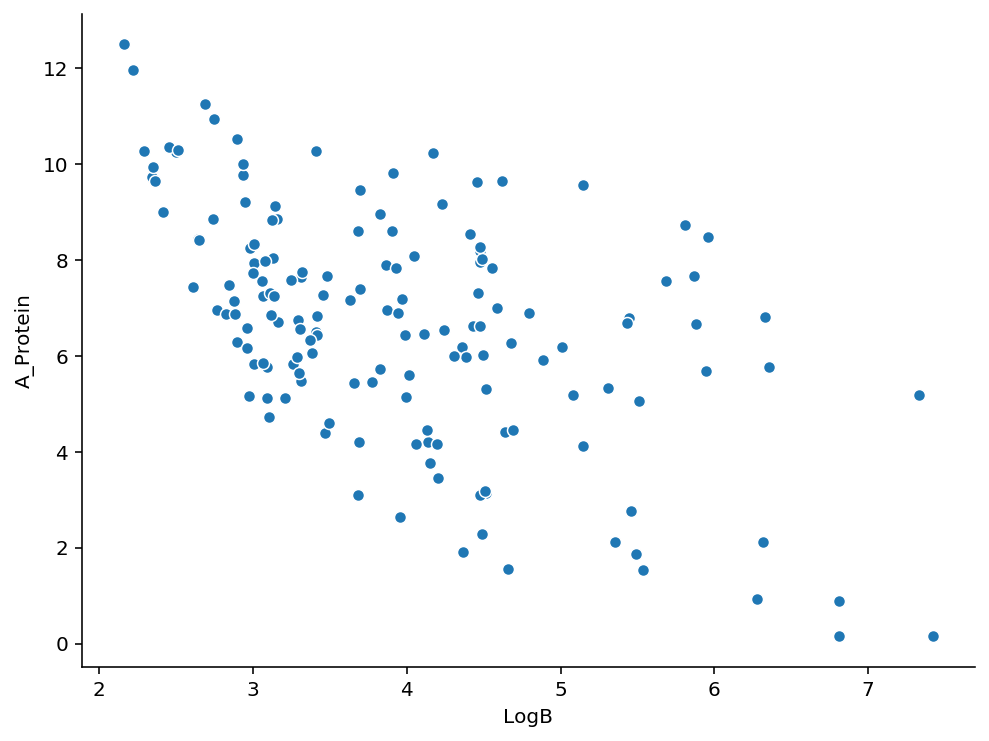

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x='LogB',y='A_Protein',data=df[df['Mean']>100])   # Here we set an extrinsic noise regime threshold of mu >100 (mu= mean protein copy number)
sns.despine()

The downward relation will be model with a simple linear regression:

In [6]:
 slope, intercept, r_value, p_value, std_err = stats.linregress(df[df['Mean']>30]['LogB'],y=df[df['Mean']>30]['A_Protein'])
slope, intercept

(-0.7642039668013618, 9.024036057426194)

In [7]:
def sample_high_regime(p):  
    logB=(4.5) * np.random.random_sample(p) + 2.7
    a=slope*logB+intercept+(np.random.beta(2, 1.8, size=p)-0.5)*8
    return(np.exp(logB),abs(a))

- This simple model allow us to augment the dataset in this particular regime

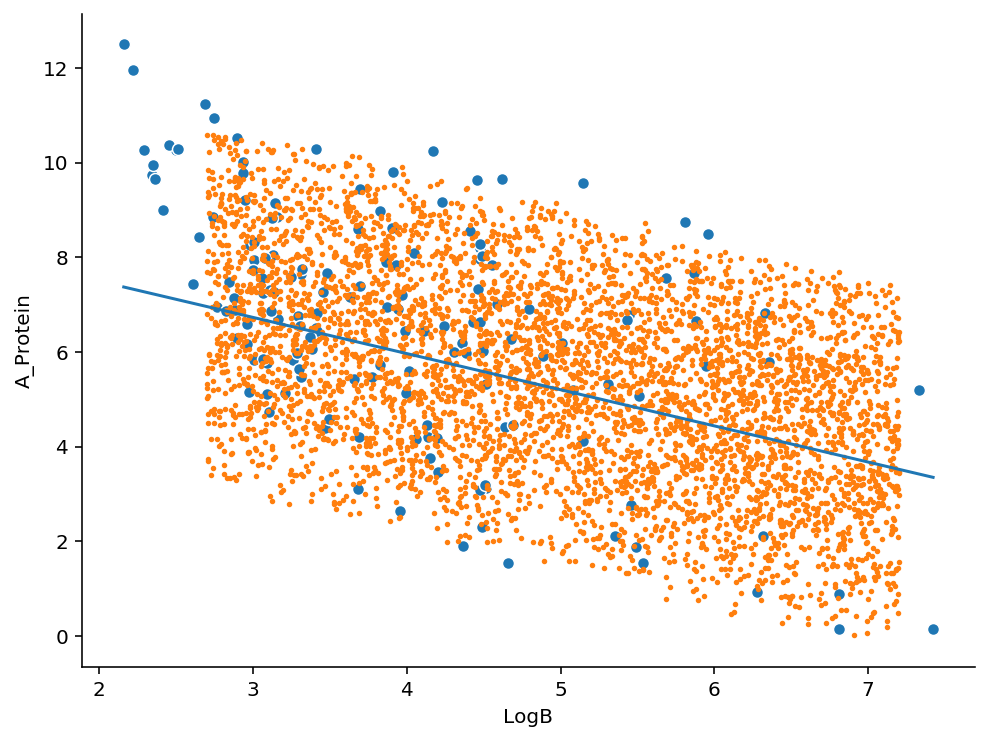

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x='LogB',y='A_Protein',data=df[df['Mean']>100])
X=np.linspace(df[df['Mean']>100]['LogB'].min(),df[df['Mean']>100]['LogB'].max(),100)
Y= slope*X+ intercept
sns.lineplot(x=X,y=Y)
Z=sample_high_regime(5000)
plt.scatter(np.log(Z[0]), y=Z[1], c='tab:orange',s=3)
sns.despine()

Here, we have augmented the original dataset (blue points) by adding beta noise to the regression line uniformly on $[2.8,7]$ (orange dots)

## Intrisic noise regime

- Let's plot the data from Taniguchi et al, 2010

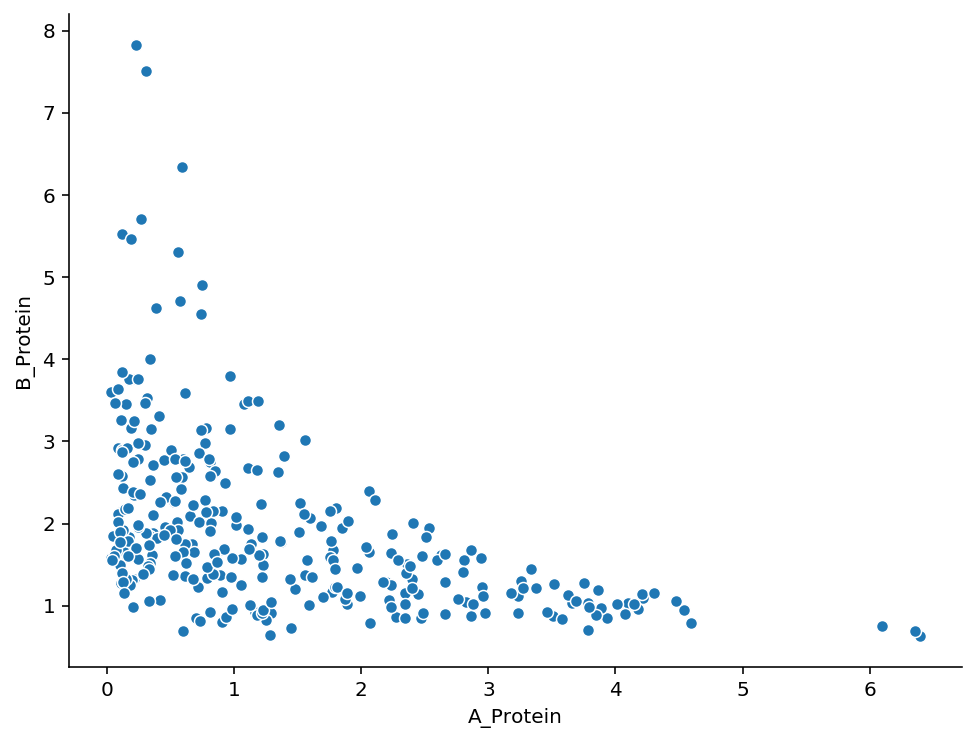

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(y='B_Protein',x='A_Protein',data=df[df['Mean']<5])  # Here we set an extrinsic noise regime threshold of mu <5 (mu= mean protein copy number)
sns.despine()

Here the relation is a bit more complex to guess and we modeled it with the following sampling algorithm:

In [10]:
def sample_low_regime(p):
    A=(4.5) * np.random.random_sample(p)+0.1
    B=0.5+(np.random.beta(3.6, 2.0, size=p))/(A/4+0.15)
    return(A,abs(B))

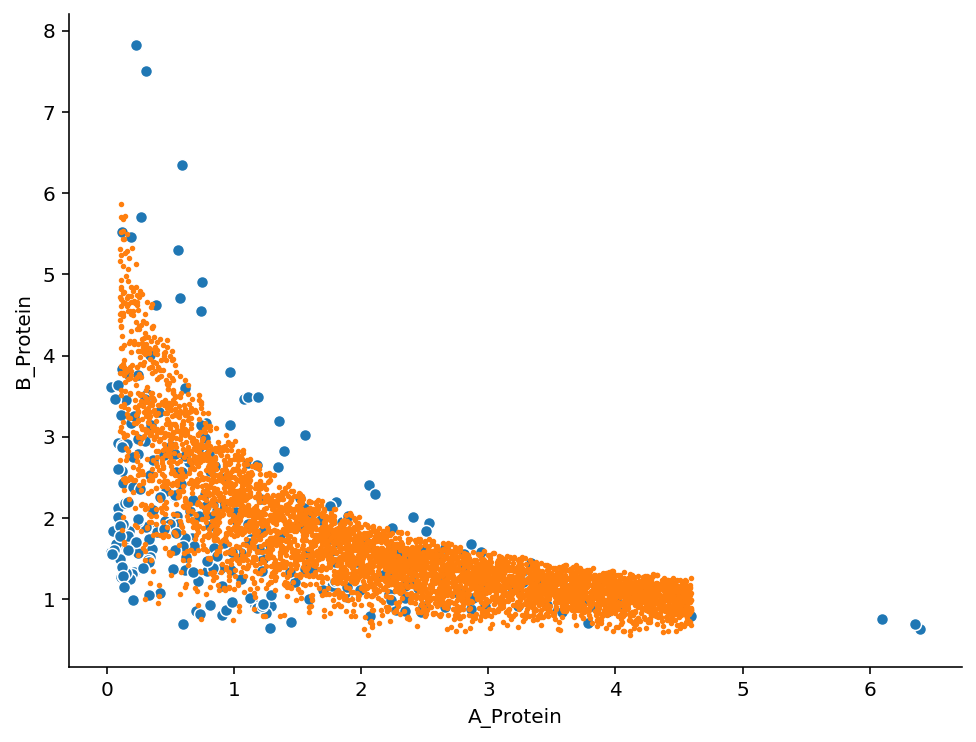

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(y='B_Protein',x='A_Protein',data=df[df['Mean']<5])
Z=sample_low_regime(5000)
plt.scatter(Z[0], y=Z[1], c='tab:orange',s=3)
sns.despine()